In [42]:
import numpy as np
import MITgcmutils
import matplotlib.pyplot as plt
from utils.resample_to_latlon import resample_to_latlon

path_grid = "ECCO2/LLC270/ECCO-Darwin_extension/grid"
path_3d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d"
path_2d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d"

/scratch/somanshu/DeepCarbonMapping/venv_cm/lib/python3.11/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


#### Variable list

In [2]:
fldList_3d = ['TRAC01','ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01',
              'DFrITr01','gDAR01','cDIC','cDIC_PIC','respDIC','rDIC_DOC','rDIC_POC','dDIC_PIC']
fldList_2d = ['ETAN','oceFWflx','SFLUX','TFLUX','oceSPflx','oceQsw','fluxCO2','gDICsurf',
           'gDICEpr','gALKEpr','gNO3Epr','gNO2Epr','gNH4Epr','gO2Epr','gPO4Epr','gFeTEpr','gSiO2Epr']

mapping_3d = list(zip(range(len(fldList_3d)),fldList_3d))
mapping_2d = list(zip(range(len(fldList_2d)),fldList_2d))

variable_selection_2d = [6,8]
variable_selection_3d = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14]


display(mapping_3d)
print()
display(mapping_2d)

variable_names = [mapping_3d[idx][1] for idx in variable_selection_3d] + [mapping_2d[idx][1] for idx in variable_selection_2d]

[(0, 'TRAC01'),
 (1, 'ADVxTr01'),
 (2, 'ADVyTr01'),
 (3, 'ADVrTr01'),
 (4, 'DFxETr01'),
 (5, 'DFyETr01'),
 (6, 'DFrETr01'),
 (7, 'DFrITr01'),
 (8, 'gDAR01'),
 (9, 'cDIC'),
 (10, 'cDIC_PIC'),
 (11, 'respDIC'),
 (12, 'rDIC_DOC'),
 (13, 'rDIC_POC'),
 (14, 'dDIC_PIC')]

[(0, 'ETAN'),
 (1, 'oceFWflx'),
 (2, 'SFLUX'),
 (3, 'TFLUX'),
 (4, 'oceSPflx'),
 (5, 'oceQsw'),
 (6, 'fluxCO2'),
 (7, 'gDICsurf'),
 (8, 'gDICEpr'),
 (9, 'gALKEpr'),
 (10, 'gNO3Epr'),
 (11, 'gNO2Epr'),
 (12, 'gNH4Epr'),
 (13, 'gO2Epr'),
 (14, 'gPO4Epr'),
 (15, 'gFeTEpr'),
 (16, 'gSiO2Epr')]

In [3]:
def conversion(value,variable_name,time_unit="y"):
    mol_s = ['ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01','DFrITr01']
    mol_m3_s = ['cDIC_PIC','respDIC','rDIC_DOC','rDIC_POC','dDIC_PIC']
    mol_m2_s = ['fluxCO2']
    other = ['TRAC01','gDICEpr']
    time_conversion = {"y":3600 * 24 * 365,
                       "d": 3600 * 24,
                       "h": 3600,
                       "s": 1}
    carbon_conversion = 12
    mmol_to_mol = 10**-3
    
    if variable_name in mol_s:
        #  f[x,y,z] * 10^-3 * 12 * (3600 * 24 * 365)
        # print("mol_s ran")
        output = value * mmol_to_mol * carbon_conversion * time_conversion[time_unit]
        
    elif variable_name in mol_m3_s:
        # f[x,y,z] * 10^-3 * DXC[x,y] * DYC[x,y] * DRF[z] * hFacC[x,y,z] * 12 * (3600 * 24 * 365)
        output = value * mmol_to_mol * \
                 dxc * dyc * drf[:, np.newaxis, np.newaxis] * hfacc * \
                 carbon_conversion * \
                 time_conversion[time_unit]
        
    elif variable_name in mol_m2_s:
        # f[x,y,z] * 10^-3 * DXC[x,y] * DYC[x,y] * hFacC[x,y,0] * 12 * (3600 * 24 * 365)
        output = value * mmol_to_mol * \
                 dxc * dyc * hfacc[0] * \
                 carbon_conversion * \
                 time_conversion[time_unit]
        
    elif variable_name == "gDICEpr":
        # f[x,y,z] * 10^-3 * DXC[x,y] * DYC[x,y] * DRF[z] * hFacC[x,y,0] * 12 * (3600 * 24 * 365)
        output = value * mmol_to_mol * \
                 dxc * dyc * drf[0] * hfacc[0] *\
                 carbon_conversion * \
                 time_conversion[time_unit]
        
    elif variable_name == "TRAC01":
        # f[x,y,z] * 10^-3
        output = value * mmol_to_mol

    else: "not found"
        
    return output

In [57]:
len(variable_names)

15

In [62]:
# testing conversion
h = 0
x = 1305
y = 224
var = 14

inputs = {"dxc": float(dxc[x][y]),
          "dyc": float(dyc[x][y]),
          "drf(not c)": float(drf[h]),
          "hfacc": float(hfacc[h][x][y])}

carbon_conversion = 12
mmol_to_mol = 10**-3
time_conversion = 3600 * 24 * 365

if var in range(13):
    org_value = d_3[var][h][x][y]
    print(f"Testing:\nfor location: depth_idx = 0, lon_idx = 1305 lat_idx = 224 variable = {variable_names[var]}")
    print("org_value:",org_value)
    output_func = conversion(d_3[var],variable_names[var])
    print("conversion function output:",output_func[h][x][y])
else:
    org_value = d_2[15-var][x][y]
    print(f"Testing:\nfor location: lon_idx = 1305 lat_idx = 224 variable = {variable_names[var]}")
    print("org_value:",org_value)
    output_func = conversion(d_2[15-var],variable_names[var])
    print("conversion function output:",output_func[x][y])


# manual calc
if var ==0:
    print("\ninputs:",inputs)
    manual = d_3[var][h][x][y] * carbon_conversion

if var in range(1,8):
    print("\ninputs:",inputs)
    manual = d_3[var][h][x][y] * mmol_to_mol * time_conversion * carbon_conversion

if var in range(8,13):
    print("\ninputs:",inputs)
    manual = d_3[var][h][x][y] * mmol_to_mol * time_conversion * carbon_conversion * \
                dxc[x][y] * dyc[x][y] * drf[h] * hfacc[h][x][y] 

if var ==13:
    print("\ninputs:",inputs)
    manual = d_2[15-var][x][y] * mmol_to_mol * time_conversion * carbon_conversion * \
                dxc[x][y] * dyc[x][y] * hfacc[0][x][y] 

if var ==14:
    print("\ninputs:",inputs)
    manual = d_2[15-var][x][y] * mmol_to_mol * time_conversion * carbon_conversion * \
                dxc[x][y] * dyc[x][y] * drf[0] * hfacc[0][x][y] 


print("manual_value:", manual)

Testing:
for location: depth_idx = 0, lon_idx = 1305 lat_idx = 224 variable = gDICEpr
org_value: 8368115032.282083
conversion function output: 4.042142034661395e+25

inputs: {'dxc': 37059.0234375, 'dyc': 34443.08984375, 'drf(not c)': 10.0, 'hfacc': 1.0}
manual_value: 4.042142034661395e+25


#### importing data

In [36]:
d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.0000002232",rec=variable_selection_2d)
d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.0000002232",rec=variable_selection_3d)

# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/YC")
dxc = MITgcmutils.mds.rdmds(f"{path_grid}/DXC")
dyc = MITgcmutils.mds.rdmds(f"{path_grid}/DYC")
hfacc = MITgcmutils.mds.rdmds(f"{path_grid}/hFacC")

lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

#### Conversion

In [38]:
# for testing
h = 0
x = 1305
y = 224
var = 8

# convert 3D variables
for var_idx in range(13):
    print(var_idx,variable_names[var_idx])
    print("before", d_3[var_idx][h][x][y])
    d_3[var_idx] = conversion(d_3[var_idx],variable_names[var_idx])
    print("after", d_3[var_idx][h][x][y],"\n")

# convert 2D variables
for var_idx in range(2):
    print(var_idx,variable_names[13+var_idx])
    print("before", d_2[var_idx][x][y])
    d_2[var_idx] = conversion(d_2[var_idx],variable_names[13+var_idx])
    print("after", d_2[var_idx][x][y],"\n")
    

0 TRAC01
before 1863.544921875
after 1.863544921875 

1 ADVxTr01
before -25316414.0
mol_s ran
after -9580541182848.0 

2 ADVyTr01
before -8700825.0
mol_s ran
after -3292670606400.0005 

3 ADVrTr01
before 0.0
mol_s ran
after 0.0 

4 DFxETr01
before 18318.302734375
mol_s ran
after 6932231940.375 

5 DFyETr01
before 14012.0439453125
mol_s ran
after 5302605814.3125 

6 DFrETr01
before 0.0
mol_s ran
after 0.0 

7 DFrITr01
before 0.0
mol_s ran
after 0.0 

8 cDIC_PIC
before 1.3829547640398232e-07
after 668023749.9359655 

9 respDIC
before 0.0
after 0.0 

10 rDIC_DOC
before 1.8848401168725104e-06
after 9104549155.496895 

11 rDIC_POC
before 5.0408839769033875e-08
after 243495326.4419397 

12 dDIC_PIC
before 4.631276750988178e-10
after 2237096.2106879796 

0 fluxCO2
before -1.128885560319759e-05
after -5452979264.849284 

1 gDICEpr
before 1.7323822021353408e-06
after 8368115032.282083 



#### Flatten 3d data

In [39]:
# Calculating delta depth
drc = np.diff(depth_c, axis=0) * -1
drc = drc[:,0,0]

drf = np.diff(depth_f, axis=0) * -1
drf = drf[:,0,0]

# getting index of top 100m depth
idx_top_100m = np.where(depth_c>=-100)[0]

In [40]:
# Using numpy
delta_depth_f_vec = drf[idx_top_100m, np.newaxis, np.newaxis]
flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m

#### Combine and process variables

In [43]:
# combine data
combined_data = np.concatenate((flattened_d3, d_2), axis=0)

# create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
mask = combined_data[0]==0
combined_data[:,mask] = np.nan

# Interpolating the curvilinear line to the cartesian plane
new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
new_grid_min_lat, new_grid_max_lat = -90, 90
new_grid_min_lon, new_grid_max_lon = -180, 180
new_shape = (combined_data.shape[0],
             int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
             int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))

variables_cart = np.empty(new_shape)

for variable in range(combined_data.shape[0]):  
    lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                resample_to_latlon(lon,lat,combined_data[variable],
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.NaN,
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
                                                                         
variables_cart.shape

(15, 360, 720)

#### plotting

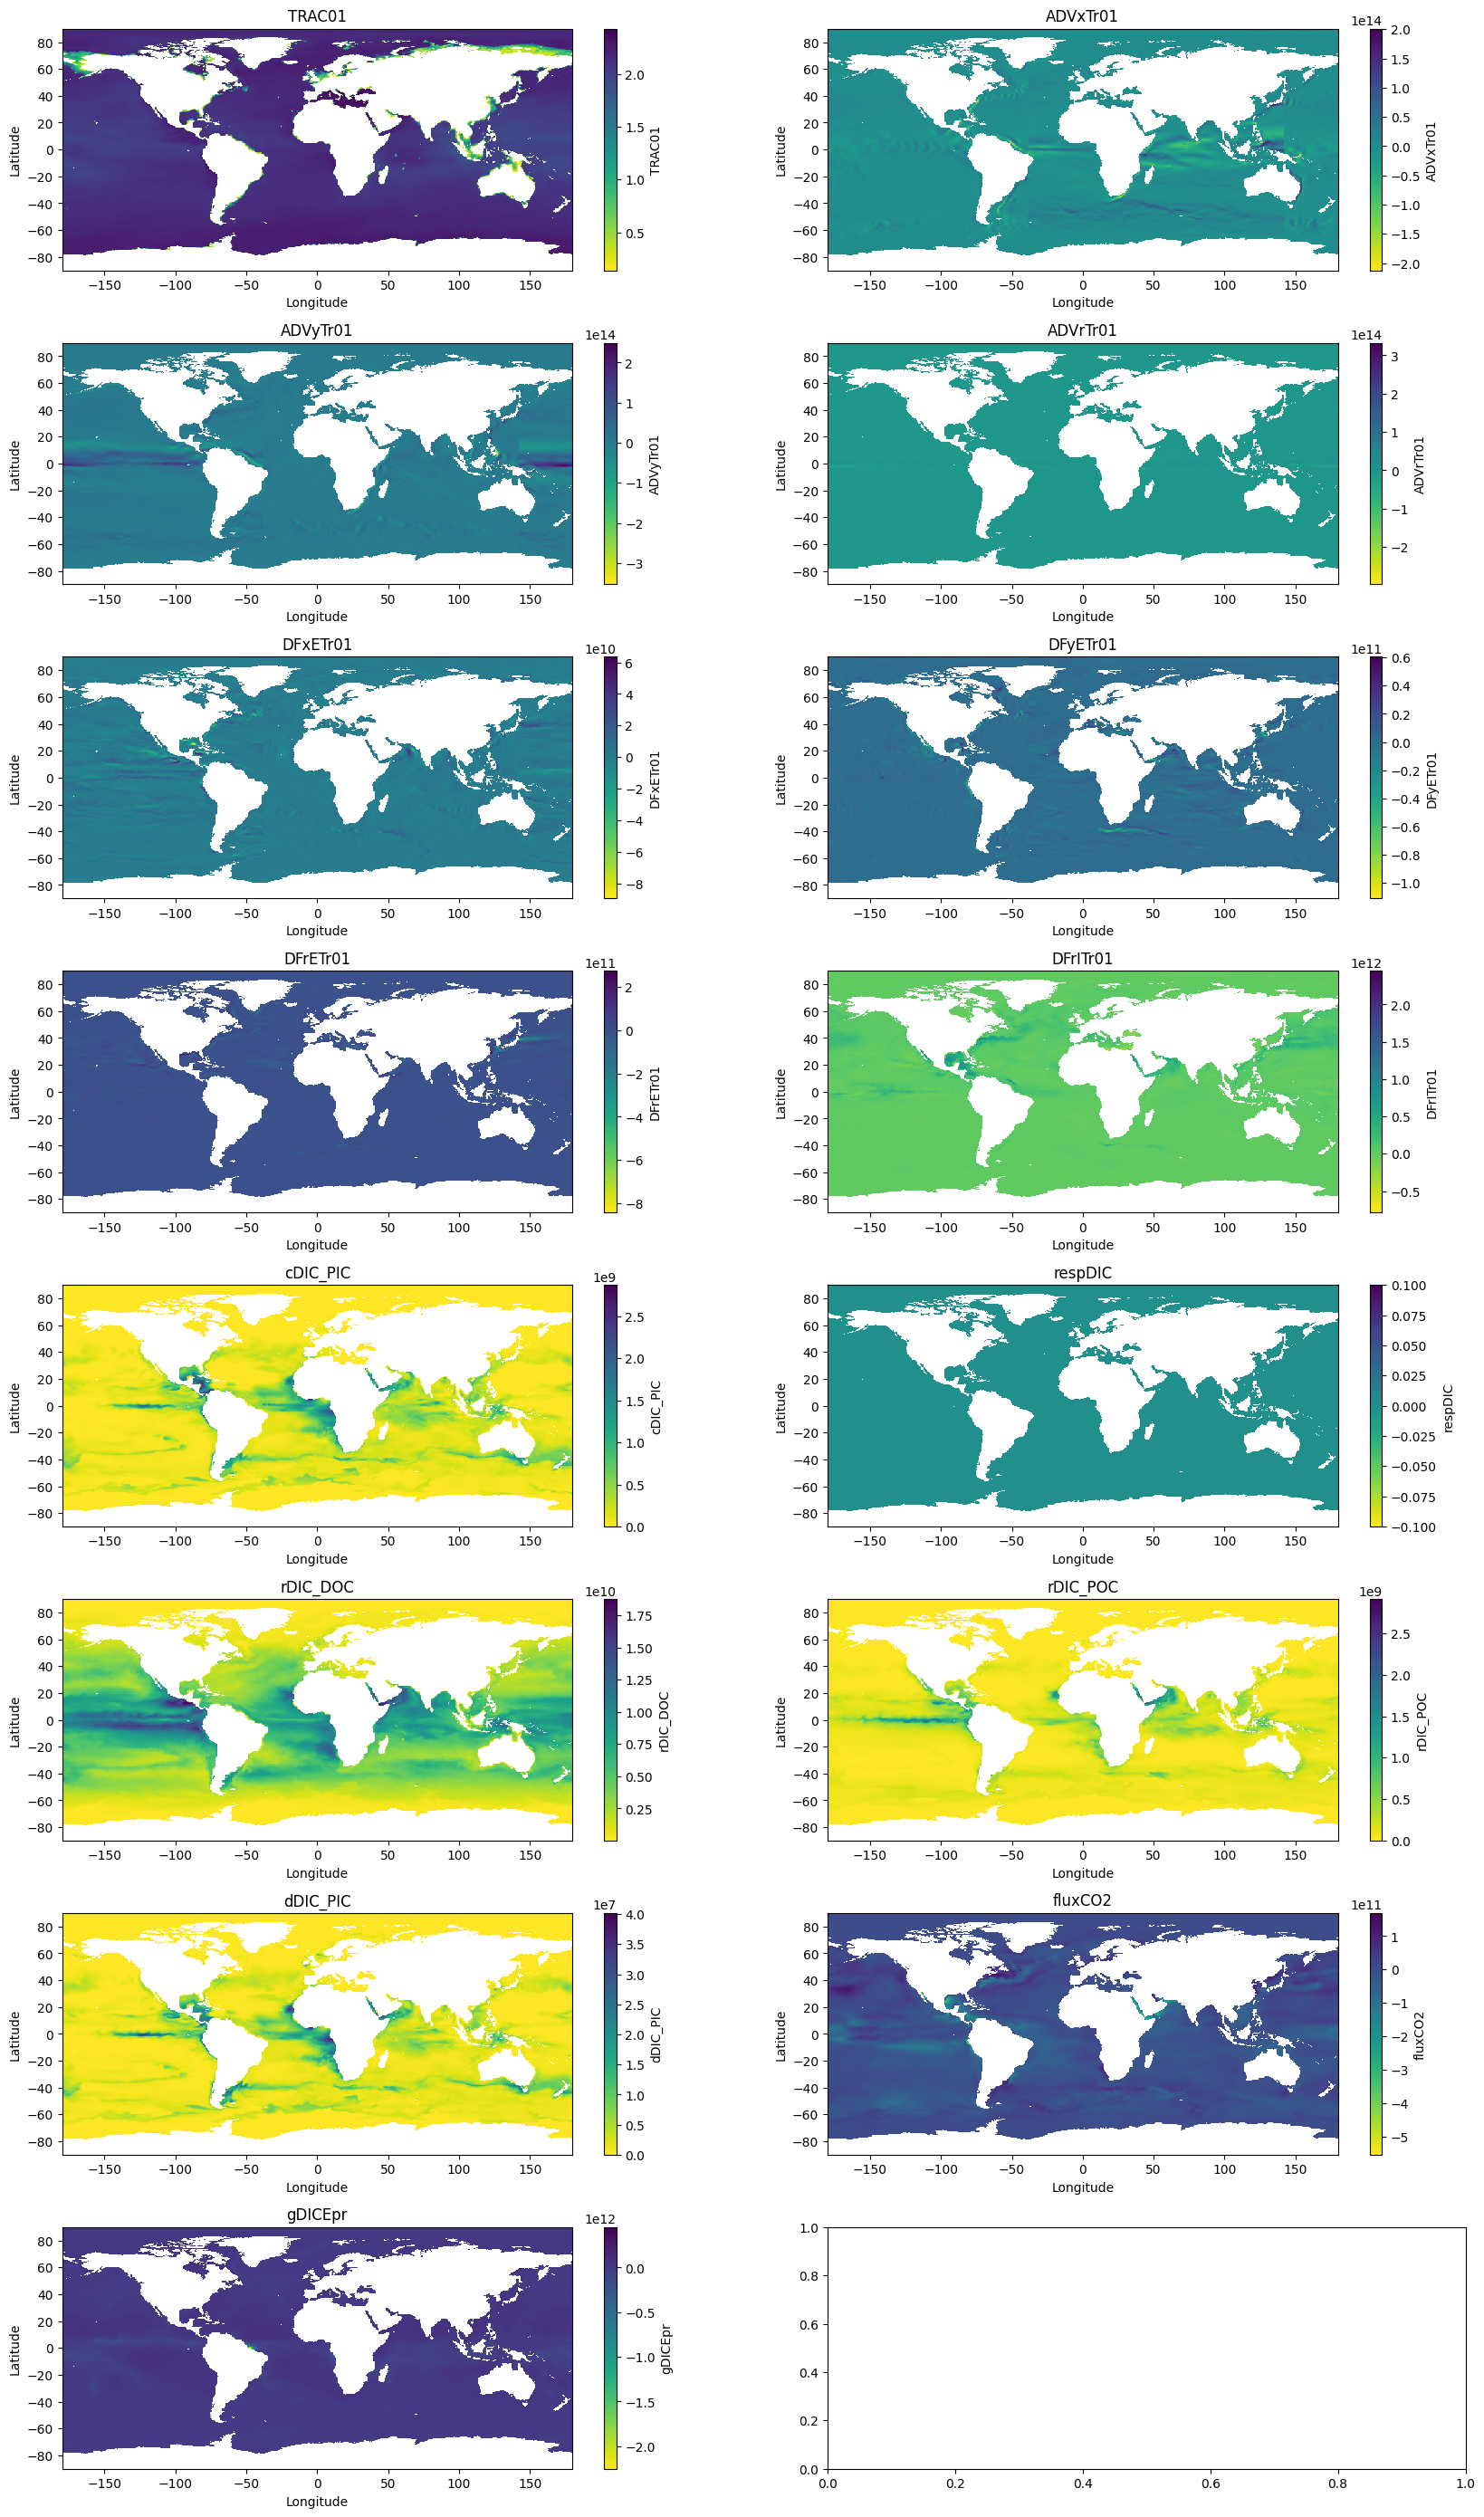

In [48]:
# pcolormesh
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = variables_cart[var_idx]  # Color values for the current variable

    # Scatter plot for the current variable
    pcolor = ax.pcolormesh(lon_cart,lat_cart, values, cmap='viridis_r', shading='auto')
    cbar = plt.colorbar(pcolor, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)

plt.savefig("compressed and converted.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Scatter plot for surface level data
lat_flattened = lon.flatten()
lon_flattened = lat.flatten()

# Create a single figure with 7 rows and 2 columns
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names[0:-2]):
    ax = axes[var_idx]
    values = d_3[var_idx][0].flatten()  # Color values for the current variable

    # Scatter plot for the current variable
    scatter = ax.scatter(lat_flattened, lon_flattened, c=values, cmap='Blues', s=5, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)
    
for var_idx, var_name in enumerate(variable_names[-2:]):
    ax = axes[var_idx+13]
    values = d_2[var_idx].flatten()  # Color values for the current variable

    # Scatter plot for the current variable
    scatter = ax.scatter(lat_flattened, lon_flattened, c=values, cmap='Blues', s=5, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)

plt.savefig("top layer 3d data.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Scatter plot for integrated data
lat_flattened = lon.flatten()
lon_flattened = lat.flatten()

# Create a single figure with 7 rows and 2 columns
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = combined_data[var_idx].flatten()  # Color values for the current variable

    # Scatter plot for the current variable
    scatter = ax.scatter(lat_flattened, lon_flattened, c=values, cmap='Blues', s=5, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)
    
plt.savefig("compressed 3d data.png", dpi=300, bbox_inches="tight")
# plt.show()

0.46748545998707414


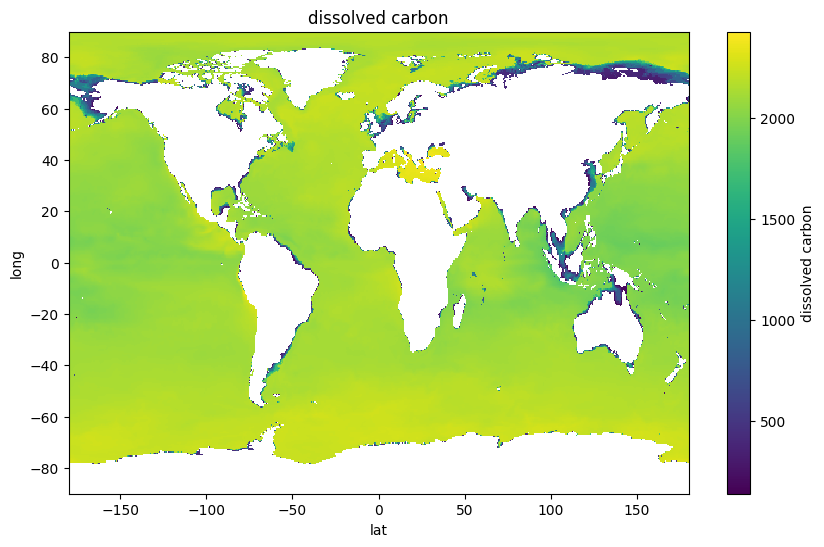

In [63]:
import time

start = time.perf_counter()
new_grid_delta_lat = 0.5
new_grid_delta_lon = 0.5

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180
field = combined_data[0]
field[field==0] = np.nan

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        resample_to_latlon(lon, \
                                lat, \
                                field,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
print(time.perf_counter()-start)



In [22]:
new_grid_lon_centers.shape

(180, 360)

In [24]:
field_nearest_1deg.shape

(180, 360)

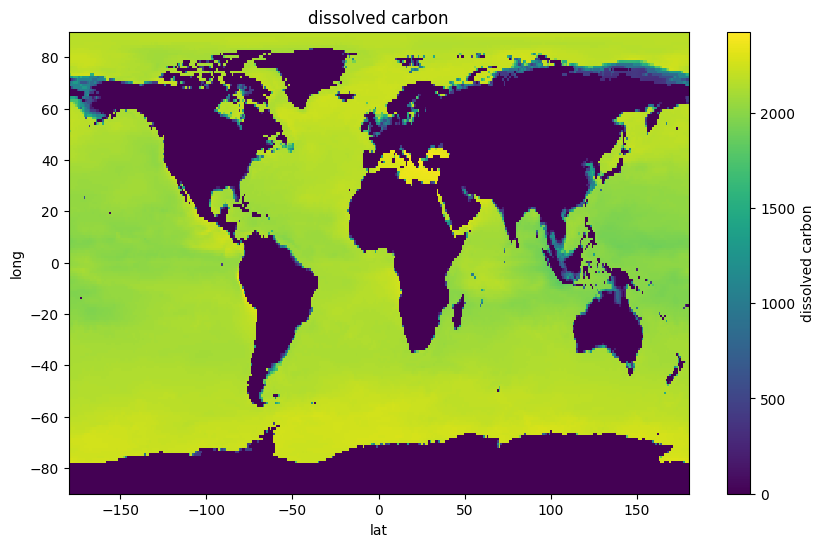

#### Excel Test

In [58]:
drc = d_3[1]
variable_1_flattened = variable_1_data.reshape(variable_1_data.shape[0], -1)  # Shape: (50, 949770)

# Combine delta depth values with the flattened data
combined_data = np.column_stack((drf, variable_1_flattened))

# Convert to DataFrame for better Excel formatting
column_names = ['Delta Depth'] + [f'Value_{i}' for i in range(variable_1_flattened.shape[1])]
df_excel = pd.DataFrame(combined_data, columns=column_names).T

# Save to Excel
excel_path = "variable_1_depth_comparison.xlsx"
df_excel.to_excel(excel_path, index=False)
